# Solar-like Oscillations with the Physical Line Emulator

This worked example shows how to combine SPICE's surface pulsation framework with the `PhysicalLineEmulator` to synthesize realistic, time-dependent line profiles for a solar-type star. We:

1. Build a solar analog represented by an icosphere mesh.
2. Add a handful of low-degree p-mode pulsations that mimic five-minute oscillations.
3. Vary the global effective temperature and surface gravity slightly in phase with the pulsations.
4. Use the physical line emulator to compute a disk-integrated Fe I line around 5250 Å.
5. Visualize how the spectrum, line depth, and pulsation velocities evolve over time.

## Imports and helper configuration

We only need standard scientific Python packages plus the core SPICE APIs for building mesh models, evaluating pulsations, and synthesizing spectra.

In [22]:
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
%matplotlib inline

from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
from spice.spectrum import simulate_observed_flux
from spice.spectrum.physical_line_emulator import PhysicalLineEmulator

## Build a solar-like mesh and instantiate the physical line emulator

The line emulator models a single photospheric line with configurable broadening physics and limb darkening. We keep the mesh coarse enough to evaluate quickly yet fine enough to capture surface variations.

In [23]:
# Basic solar properties
base_teff = 5777.0  # K
base_logg = 4.44    # cgs
target_line = 5250.0  # Angstroms

# Physical line emulator with mild convective blueshift and quadratic limb darkening
line_emulator = PhysicalLineEmulator(
    line_center=target_line,       # [Å] — Fe I region near 5250 Å

    # --- Line strength ---
    line_depth=0.25,               # multiplicative depth (solar weak Fe line)
                                   # 0.2–0.35 typical; 0.25 is safe & realistic

    # --- Atomic species ---
    atomic_mass=56.0,              # Fe I (A=56)

    # --- Gaussian width components ---
    v_micro=1.0,                   # km/s — solar photospheric microturbulence
                                   # (feeds into σ_micro = v_micro * λ / c)

    # --- Lorentzian/damping baseline ---
    gamma0=0.02,                   # Å — mild photospheric damping for weak Fe lines
                                   # Your class will scale this by Teff/logg

    # --- Voigt kernel ---
    line_profile_kind="voigt",     # matches get_line_profile_id("voigt")

    # --- Limb darkening ---
    limb_law="quadratic",          # must be recognized by get_limb_darkening_law_id
    limb_coeffs=(0.29, 0.34),      # solar coefficients at 5000–5500 Å

    # --- Convective blueshift ---
    use_convective_shift=True,     # enable μ-dependent convective shift
    v_conv0=0.25,                  # km/s at μ=0   (typical Fe I blueshift 200–300 m/s)

    # --- Gravity scaling exponent for gamma ---
    gamma_g_alpha=0.5,             # keep default; physically reasonable
)

# Construct a mesh with Teff and logg parameters on every surface element
parameter_names = ["Teff", "logg"]
base_params = jnp.array([base_teff, base_logg])
base_mesh = IcosphereModel.construct(
    n_vertices=2000,
    radius=1.0,
    mass=1.0,
    parameters=base_params,
    parameter_names=parameter_names,
    max_pulsation_mode=6,
    max_fourier_order=5,
)

## Add a small set of solar-like oscillation modes

We represent the global p-mode spectrum with three low-degree spherical harmonics. The Fourier amplitude values are the fractional changes in radius, so we keep them at the millimag level that is typical for the Sun.

In [24]:
def add_solar_like_modes(mesh):
    modes = [
        {"label": "Radial p-mode", "m": 0, "l": 0, "period": 5.0 * 60.0, "amplitude": 3.0e-3, "phase": 0.0},
        {"label": "Dipole p-mode", "m": 1, "l": 1, "period": 4.2 * 60.0, "amplitude": 1.5e-3, "phase": np.pi / 3},
        {"label": "Quadrupole p-mode", "m": 2, "l": 2, "period": 6.5 * 60.0, "amplitude": 1.0e-3, "phase": -np.pi / 4},
    ]

    pulsating = mesh
    for mode in modes:
        fs_params = jnp.array([[mode["amplitude"], mode["phase"]]])
        pulsating = add_pulsation(
            pulsating,
            m_order=mode["m"],
            l_degree=mode["l"],
            period=mode["period"],
            fourier_series_parameters=fs_params,
        )
    return pulsating, modes

pulsating_mesh, solar_modes = add_solar_like_modes(base_mesh)
print(f"Configured {len(solar_modes)} pulsation modes.")

Configured 3 pulsation modes.


## Define the observing setup and the slowly varying atmospheric response

Solar-like oscillations perturb the effective temperature and surface gravity by a few Kelvin and milli-dex. We evaluate two hours of activity sampled every three minutes and compute spectra near the chosen Fe I line.

In [25]:
# Wavelength grid around the Fe I 5250 Å line
wavelengths = jnp.linspace(5250-2, 5250+2, 2048)
log_wavelengths = jnp.log10(wavelengths)

# Observation timeline (two hours sampled every three minutes)
times = np.linspace(0.0, 2.0 * 3600.0, 200)

teff_idx = parameter_names.index("Teff")
logg_idx = parameter_names.index("logg")

puls_models = []

# Small, phase-correlated variations in Teff and logg
def teff_variation(time_s):
    return (
        base_teff
        + 8.0 * np.sin(2 * np.pi * time_s / (5.0 * 60.0))
        + 3.0 * np.sin(2 * np.pi * time_s / (8.0 * 60.0) + 0.4)
    )

def logg_variation(time_s):
    return base_logg + 4.0e-4 * np.sin(2 * np.pi * time_s / (6.0 * 60.0) + 0.2)

spectral_snapshots = []
for t in tqdm(times, desc="Evaluating spectra"):
    # Evaluate pulsations for this timestamp
    pulsated = evaluate_pulsations(pulsating_mesh, t)

    # Update the atmospheric parameters uniformly across the surface
    params = pulsated.parameters
    params = params.at[:, teff_idx].set(teff_variation(t))
    params = params.at[:, logg_idx].set(logg_variation(t))
    pulsated = pulsated._replace(parameters=params)
    puls_models.append(pulsated)

    # Synthesize the spectrum
    flux = simulate_observed_flux(
        line_emulator.intensity,
        pulsated,
        log_wavelengths,
    )

    spectral_snapshots.append({
        "time_min": t / 60.0,
        "teff": teff_variation(t),
        "logg": logg_variation(t),
        "max_los_velocity": float(jnp.max(jnp.abs(pulsated.los_velocities))),
        "flux": np.asarray(flux),
    })

print(f"Computed {len(spectral_snapshots)} spectra covering {times[-1] / 3600:.1f} hours.")

Evaluating spectra: 100%|██████████| 200/200 [04:17<00:00,  1.29s/it]

Computed 200 spectra covering 2.0 hours.


(<Figure size 1000x1200 with 2 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>)

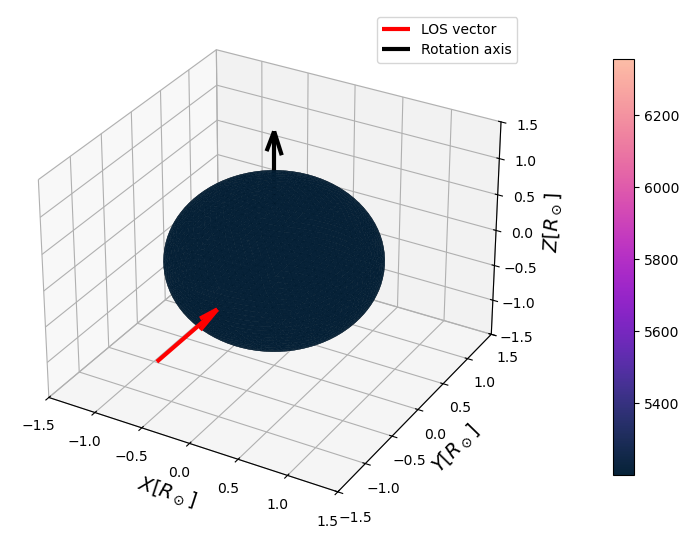

In [26]:
from spice.plots.plot_mesh import plot_3D

plot_3D(pulsated, property=0)

## Inspect the thermodynamic variations and pulsation velocities

The variations stay at the few-Kelvin and few $10^{-4}$ dex level, while the surface velocities remain below 1 km/s, consistent with solar five-minute oscillations.

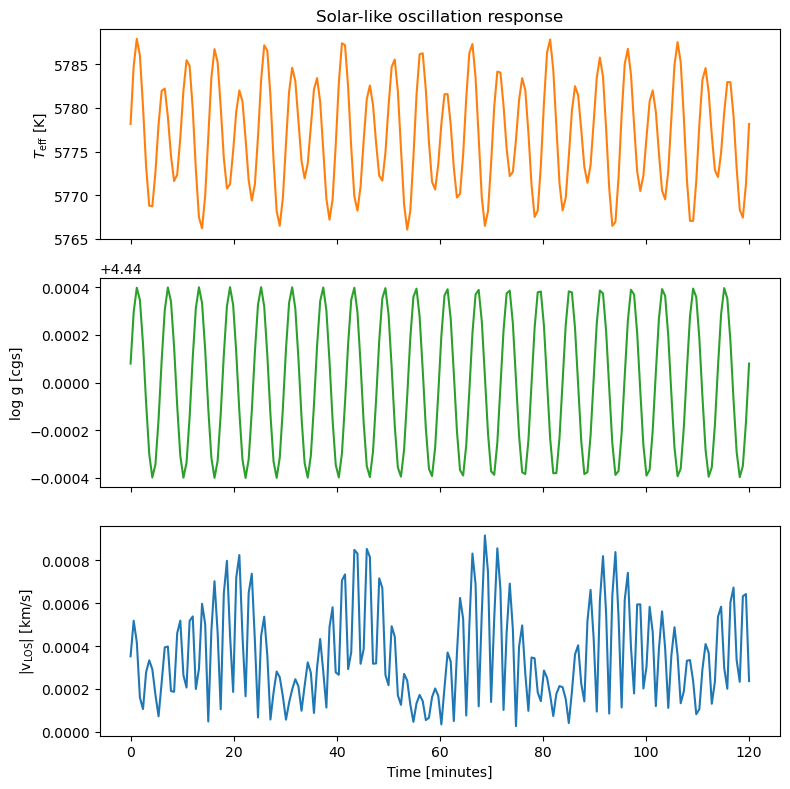

In [27]:
times_min = np.array([snap["time_min"] for snap in spectral_snapshots])
teffs = np.array([snap["teff"] for snap in spectral_snapshots])
loggs = np.array([snap["logg"] for snap in spectral_snapshots])
velocities = np.array([snap["max_los_velocity"] for snap in spectral_snapshots])

fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
ax[0].plot(times_min, teffs, color="tab:orange")
ax[0].set_ylabel(r"$T_{\mathrm{eff}}$ [K]")
ax[0].set_title("Solar-like oscillation response")

ax[1].plot(times_min, loggs, color="tab:green")
ax[1].set_ylabel(r"log g [cgs]")

ax[2].plot(times_min, velocities, color="tab:blue")
ax[2].set_ylabel(r"|v$_{\mathrm{LOS}}$| [km/s]")
ax[2].set_xlabel("Time [minutes]")
plt.tight_layout()
plt.show()

## Track spectral variability across the time series

We plot a subset of spectra and a time–wavelength map of the residuals relative to the average continuum to reveal breathing of the line core.

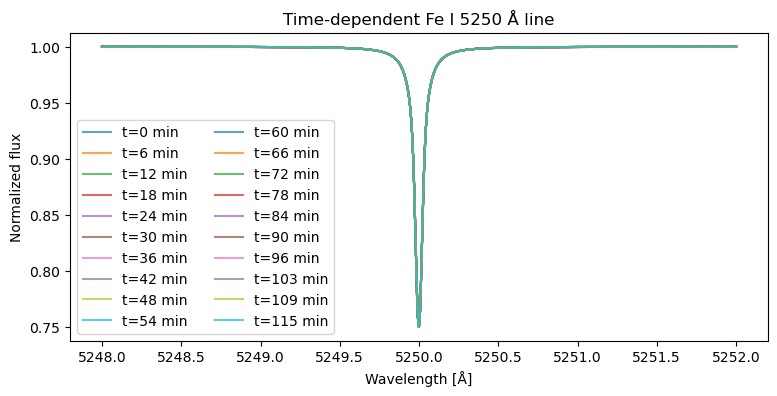

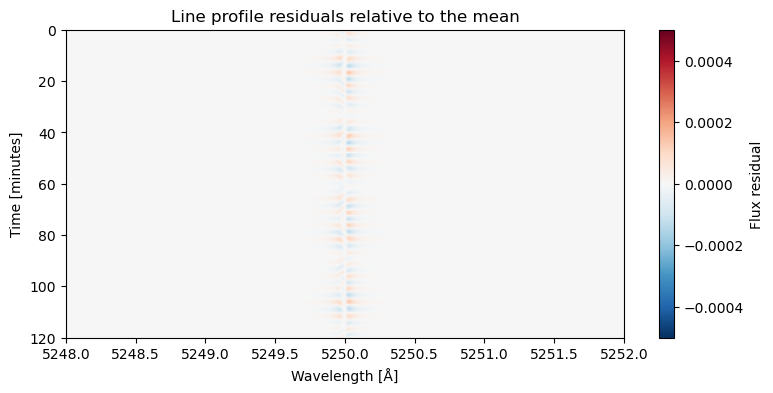

In [28]:
# Convert fluxes to numpy arrays for plotting
flux_stack = np.array([snap["flux"][:, 0] for snap in spectral_snapshots])
continuum_stack = np.array([snap["flux"][:, 1] for snap in spectral_snapshots])
normalized_flux = flux_stack / continuum_stack

fig, ax = plt.subplots(figsize=(9, 4))
for idx in range(0, len(spectral_snapshots), 10):
    ax.plot(wavelengths, normalized_flux[idx], label=f"t={times_min[idx]:.0f} min", alpha=0.7)
ax.set_xlabel(r"Wavelength [Å]")
ax.set_ylabel("Normalized flux")
ax.set_title("Time-dependent Fe I 5250 Å line")
ax.legend(loc="lower left", ncol=2)
plt.show()

# Residual map relative to the time-averaged profile
mean_profile = normalized_flux.mean(axis=0)
residuals = normalized_flux - mean_profile

fig, ax = plt.subplots(figsize=(9, 4))
im = ax.imshow(
    residuals,
    aspect="auto",
    extent=[wavelengths[0], wavelengths[-1], times_min[-1], times_min[0]],
    cmap="RdBu_r",
    vmin=-5e-4,
    vmax=5e-4,
)
ax.set_xlabel(r"Wavelength [Å]")
ax.set_ylabel("Time [minutes]")
ax.set_title("Line profile residuals relative to the mean")
plt.colorbar(im, ax=ax, label="Flux residual")
plt.show()

## Measure oscillation signatures in the line core

Finally, we track the normalized flux at the line center as a proxy observable and compare it to the underlying temperature fluctuations.

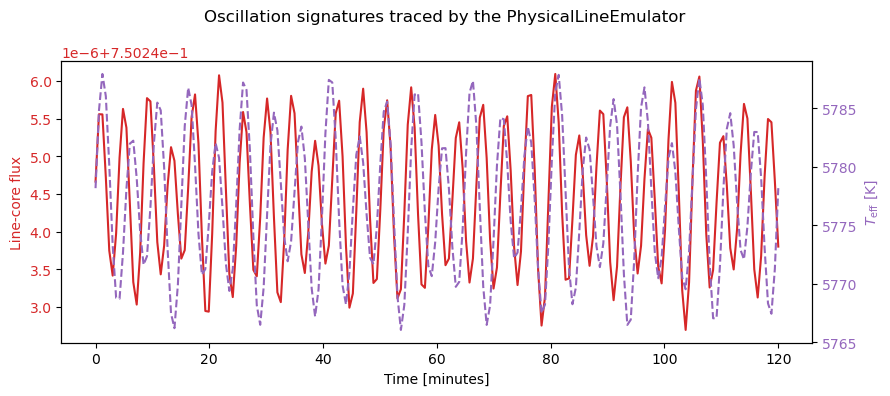

In [29]:
line_center_index = np.argmin(mean_profile)
line_core_flux = normalized_flux[:, line_center_index]

fig, ax1 = plt.subplots(figsize=(9, 4))
color = "tab:red"
ax1.set_xlabel("Time [minutes]")
ax1.set_ylabel("Line-core flux", color=color)
ax1.plot(times_min, line_core_flux, color=color, label="Line core")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = "tab:purple"
ax2.set_ylabel(r"$T_{\mathrm{eff}}$ [K]", color=color)
ax2.plot(times_min, teffs, color=color, linestyle="--", label="Teff")
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Oscillation signatures traced by the PhysicalLineEmulator")
fig.tight_layout()
plt.show()

The line-core modulation tracks the temperature oscillations closely, showing how the physical line emulator captures subtle changes in both thermodynamic structure and velocity fields. This notebook can serve as a starting point for exploring mode identification, fitting routines, or comparisons against observed Sun-as-a-star datasets.

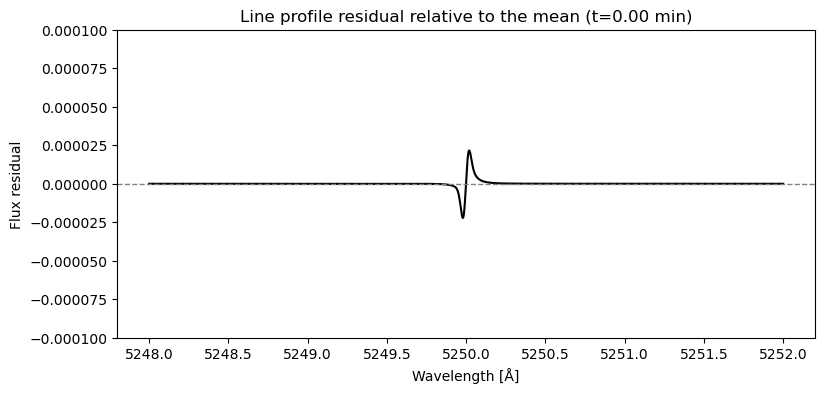

In [30]:
# Animate the line profile residuals with respect to the mean over all time steps

from matplotlib.animation import FuncAnimation

residuals = normalized_flux - mean_profile  # shape: (ntimes, nwavelengths)

fig, ax = plt.subplots(figsize=(9, 4))
line, = ax.plot(wavelengths, residuals[0], color='black')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel(r"Wavelength [Å]")
ax.set_ylabel("Flux residual")
title = ax.set_title(f"Line profile residual relative to the mean (t={times_min[0]:.2f} min)")
ax.set_ylim(-0.0001, 0.0001)

def update(frame):
    line.set_ydata(residuals[frame])
    title.set_text(f"Line profile residual relative to the mean (t={times_min[frame]:.2f} min)")
    return line, title

ani = FuncAnimation(fig, update, frames=len(times_min), interval=100, blit=False)
plt.show()


In [31]:
ani.save('line_profile_residual.gif', writer='pillow')

'pulsating_mesh_solar.gif'

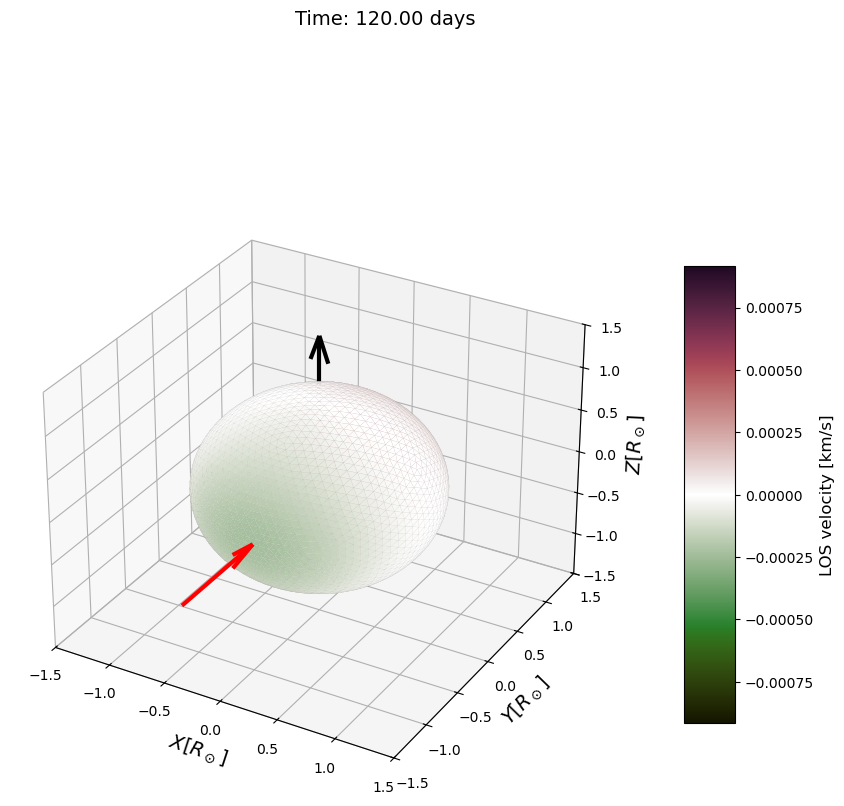

In [33]:
from spice.plots.plot_mesh import animate_single_star
import cmasher as cmr

animate_single_star(puls_models, property='los_velocities', cmap='cmr.holly', timestamps=times_min, filename='pulsating_mesh_solar.gif')